In [1]:
import sys
assert sys.version_info >= (3, 5)
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import tensorflow_probability as tfp
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
#leaky_relu = tf.keras.layers.LeakyReLU()
randN_05 = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
dim_n = 3 # Dim 4+ needs considerable fine-tuning

In [3]:
input_A = keras.layers.Input(shape=[2*dim_n])
input_B = keras.layers.Input(shape=[2*dim_n])
    
transform = keras.models.Sequential([
layers.Dense(30, kernel_initializer=randN_05, activation="relu"),
keras.layers.Dropout(rate=0.3), # To regularize higher dimensionality
layers.Dense(30, kernel_initializer=randN_05, activation="relu"),
keras.layers.Dropout(rate=0.3), # To regularize higher dimensionality
layers.Dense(1, kernel_initializer=randN_05, activation=None)])

output_A = transform(input_A)
output_B = transform(input_B)
output_C = tf.reduce_mean(output_A) - tf.math.log(tf.reduce_mean(tf.exp(output_B))) # MINE
#output_C = tf.reduce_mean(output_A) - tf.reduce_mean(tf.exp(output_B))+1 # MINE-f
MI_mod = keras.models.Model(inputs=[input_A, input_B], outputs=output_C)

In [4]:
def loss_func(inp, outp):
    '''Calculate the loss: scaled negative estimated mutual information'''
    return -outp

In [5]:
MI_mod.compile(loss=loss_func, optimizer=keras.optimizers.Nadam(lr=0.001))

In [6]:
SIGNAL_NOISE = 0.2
SAMPLE_SIZE = dim_n*6000
SIGNAL_POWER = 3

x_sample = np.random.normal(0., np.sqrt(SIGNAL_POWER), [SAMPLE_SIZE, dim_n])
y_sample = x_sample + np.random.normal(0., np.sqrt(SIGNAL_NOISE), [SAMPLE_SIZE, dim_n])

x_sample1, x_sample2 = tf.split(x_sample, num_or_size_splits=2)
y_sample1, y_sample2 = tf.split(y_sample, num_or_size_splits=2)
joint_sample = tf.concat([x_sample1, y_sample1], axis=1)
marg_sample = tf.concat([x_sample2, y_sample1], axis=1)

In [7]:
history_mi = MI_mod.fit((joint_sample, marg_sample), x_sample, epochs=30, batch_size=200)

Train on 9000 samples
Epoch 1/30
9000/9000 [==============================] - 0s 44us/sample - loss: -0.0505
Epoch 2/30
9000/9000 [==============================] - 0s 12us/sample - loss: -0.7593
Epoch 3/30
9000/9000 [==============================] - 0s 11us/sample - loss: -2.0280
Epoch 4/30
9000/9000 [==============================] - 0s 11us/sample - loss: -2.6971
Epoch 5/30
9000/9000 [==============================] - 0s 11us/sample - loss: -3.0710
Epoch 6/30
9000/9000 [==============================] - 0s 11us/sample - loss: -3.2430
Epoch 7/30
9000/9000 [==============================] - 0s 11us/sample - loss: -3.4708
Epoch 8/30
9000/9000 [==============================] - 0s 12us/sample - loss: -3.5317
Epoch 9/30
9000/9000 [==============================] - 0s 11us/sample - loss: -3.5812
Epoch 10/30
9000/9000 [==============================] - 0s 11us/sample - loss: -3.5552
Epoch 11/30
9000/9000 [==============================] - 0s 12us/sample - loss: -3.6636
Epoch 12/30
9000/90

In [8]:
def theoretic_mutual_information(power,noise):
    return dim_n*0.5*np.log2(1 + power/noise)


df_mi = np.log2(np.exp(1))*np.abs(pd.DataFrame(history_mi.history)) # scaling from Nats to Bits
df_mi = df_mi.rename(columns={'loss': 'Approximated mutual information'})
history_range = range(len(df_mi))

true_mi = [theoretic_mutual_information(SIGNAL_POWER, SIGNAL_NOISE) for x in history_range]

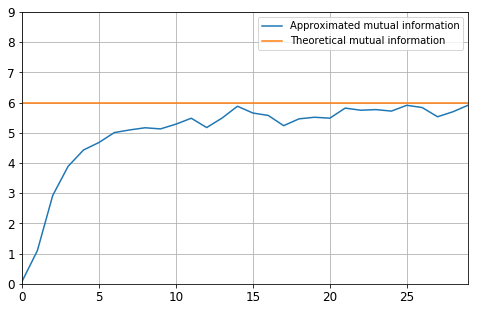

In [9]:
df_mi.plot(figsize=(8, 5))
plt.plot(history_range, true_mi, label='Theoretical mutual information')
plt.grid(True)
plt.gca().set_ylim(0, dim_n*3)
plt.legend()
#plt.tick_params(axis='x', colors='white')
#plt.tick_params(axis='y', colors='white')
plt.show()